In [1]:
from string import punctuation
from os import listdir
from collections import Counter
from nltk.corpus import stopwords
from keras.preprocessing.text import Tokenizer
from numpy import array

Using TensorFlow backend.


In [2]:
# load doc into memory
def load_doc(filename):
#     open the file as read only
    file = open(filename, 'r')
#     read all text
    text = file.read()
#     close the file
    file.close()
    return text

In [3]:
# turn a doc into clean tokens
def clean_doc(doc):
#     split into tokens by white space
    tokens = doc.split()
#     remove punctuation from each token
    table = str.maketrans('','',punctuation)
    tokens = [w.translate(table) for w in tokens]
#     remove remaining tokens that are not alphabetic
    tokens = [word for word in tokens if word.isalpha()]
#     filter out stop words
    stop_words = set(stopwords.words('english'))
    tokens = [w for w in tokens if not w in stop_words]
#     filter out short tokens
    tokens = [word for word in tokens if len(word) > 1]
    return tokens

In [4]:
# load doc and add to vocab
def add_doc_to_vocab(filename, vocab):
#     load doc
    doc = load_doc(filename)
#     clean doc
    tokens = clean_doc(doc)
#     update counts
    vocab.update(tokens)

In [5]:
# load all docs in a directory
def process_docs(directory, vocab):
    # walk through all files in the folder
    for filename in listdir(directory):
        # skip any reviews in the test set
        if filename.startswith('cv9'):
            continue
        # create the full path of the file to open
        path = directory + '/' + filename
       # add doc to vocab
        add_doc_to_vocab(path, vocab)

In [6]:
# define vocab
vocab = Counter()
# add all docs to vocab
process_docs('../txt_sentoken/pos',vocab)
process_docs('../txt_sentoken/neg',vocab)

# print the size of the vocab
print(len(vocab))

# print the top words in the vocab
print(vocab.most_common(50))

44276
[('film', 7983), ('one', 4946), ('movie', 4826), ('like', 3201), ('even', 2262), ('good', 2080), ('time', 2041), ('story', 1907), ('films', 1873), ('would', 1844), ('much', 1824), ('also', 1757), ('characters', 1735), ('get', 1724), ('character', 1703), ('two', 1643), ('first', 1588), ('see', 1557), ('way', 1515), ('well', 1511), ('make', 1418), ('really', 1407), ('little', 1351), ('life', 1334), ('plot', 1288), ('people', 1269), ('could', 1248), ('bad', 1248), ('scene', 1241), ('movies', 1238), ('never', 1201), ('best', 1179), ('new', 1140), ('scenes', 1135), ('man', 1131), ('many', 1130), ('doesnt', 1118), ('know', 1092), ('dont', 1086), ('hes', 1024), ('great', 1014), ('another', 992), ('action', 985), ('love', 977), ('us', 967), ('go', 952), ('director', 948), ('end', 946), ('something', 945), ('still', 936)]


In [7]:
# keep tokens with a min occurence
min_occurance = 2
tokens = [k for k,c in vocab.items() if c>= min_occurance]
print(len(tokens))

25767


In [8]:
# save list to file
def save_list(lines, filename):
#     convert lines to a single blob of text
    data = '\n'.join(lines)
#     open file
    file = open(filename, 'w')
#     write text
    file.write(data)
#     close file
    file.close()

# save tokens to a vocabulary file
save_list(tokens, 'vocab.txt')

In [9]:
# load doc, clean and return line of tokens
def doc_to_line(filename, vocab):
#     load the doc
    doc = load_doc(filename)
#     clean doc
    tokens = clean_doc(doc)
#     filter by vocab
    tokens = [w for w in tokens if w in vocab]
    return ' '.join(tokens)

In [10]:
# load all docs in a directory
def process_docs(directory, vocab, is_train):
    lines = list()
#     walk through all files in the folder
    for filename in listdir(directory):
#         skip any reviews in the test set
        if is_train:
            if filename.startswith('cv9'):
                continue
            else:
        #         create the full path of the file to open
                path = directory + '/' + filename
#                 load and clean the doc
                line = doc_to_line(path, vocab)
#                 add to list
                lines.append(line)
        else:
            if not filename.startswith('cv9'):
                continue
            else:
        #         create the full path of the file to open
                path = directory + '/' + filename
#                 load and clean the doc
                line = doc_to_line(path, vocab)
#                 add to list
                lines.append(line)
    return lines

In [11]:
# load the vocabulary
vocab_filename = 'vocab.txt'
vocab = load_doc(vocab_filename)
vocab = vocab.split()
vocab = set(vocab)

In [12]:
# prepare bag of words encoding of docs
def prepare_data(train_docs, test_docs, mode):
#     create the tokenizer
    tokenizer = Tokenizer()
#     fit the tokenizer on the documents
    tokenizer.fit_on_texts(train_docs)
#     encode training data set
    Xtrain = tokenizer.texts_to_matrix(train_docs, mode=mode)
#     encode test data set
    Xtest = tokenizer.texts_to_matrix(test_docs,mode=mode)
    return Xtrain, Xtest

In [13]:
# load all training reviews
positive_lines = process_docs('../txt_sentoken/pos',vocab,True)
negative_lines = process_docs('../txt_sentoken/neg',vocab,True)

# summarize what we have
print(len(positive_lines), len(negative_lines))

900 900


In [14]:
# create the tokenizer
tokenizer = Tokenizer()
# fit the tokenizer on the documents
train_docs = negative_lines + positive_lines
tokenizer.fit_on_texts(train_docs)

In [15]:
# load all test reviews
positive_lines = process_docs('../txt_sentoken/pos',vocab,False)
negative_lines = process_docs('../txt_sentoken/neg',vocab,False)
test_docs = negative_lines + positive_lines

In [16]:
ytrain = array([0 for _ in range(900)] + [1 for _ in range(900)]) 
ytest  = array([0 for _ in range(100)] + [1 for _ in range(100)])

In [17]:
from keras.models import Sequential
from keras.layers import Dense, Dropout

# evaluate a neural network model
def evaluate_mode(Xtrain, ytrain, Xtest, ytest):
    scores = list()
    n_repeats = 3
    n_words = Xtest.shape[1]
    for i in range(n_repeats):
        
        print('n_repeat: ', i)
        # define network
        model = Sequential()
        model.add(Dense(50, input_shape = (n_words,), activation ='relu'))
        model.add(Dense(1, activation = 'sigmoid'))

        # compile network
        model.compile(loss='binary_crossentropy',optimizer='adam', metrics=['accuracy'])

        # fit network
        model.fit(Xtrain, ytrain, epochs = 30, verbose = 2)
        
        # evaluate 
        loss, acc = model.evaluate(Xtest, ytest, verbose=0)
        scores.append(acc)
        print('Test Accuracy: %f' %(acc*100))
        
    return scores

In [18]:
modes = ['binary','count','tfidf','freq']

In [19]:
from pandas import DataFrame
results = DataFrame()
for mode in modes:
#     prepare data for mode
    Xtrain, Xtest = prepare_data(train_docs, test_docs, mode)
    results[mode] = evaluate_mode(Xtrain, ytrain, Xtest, ytest)

n_repeat:  0
Epoch 1/30
 - 2s - loss: 0.4626 - acc: 0.7728
Epoch 2/30
 - 2s - loss: 0.0603 - acc: 0.9922
Epoch 3/30
 - 2s - loss: 0.0159 - acc: 1.0000
Epoch 4/30
 - 3s - loss: 0.0073 - acc: 1.0000
Epoch 5/30
 - 2s - loss: 0.0040 - acc: 1.0000
Epoch 6/30
 - 2s - loss: 0.0023 - acc: 1.0000
Epoch 7/30
 - 2s - loss: 0.0015 - acc: 1.0000
Epoch 8/30
 - 2s - loss: 9.8345e-04 - acc: 1.0000
Epoch 9/30
 - 2s - loss: 7.0790e-04 - acc: 1.0000
Epoch 10/30
 - 2s - loss: 5.3167e-04 - acc: 1.0000
Epoch 11/30
 - 2s - loss: 4.1303e-04 - acc: 1.0000
Epoch 12/30
 - 2s - loss: 3.3136e-04 - acc: 1.0000
Epoch 13/30
 - 2s - loss: 2.7190e-04 - acc: 1.0000
Epoch 14/30
 - 2s - loss: 2.2668e-04 - acc: 1.0000
Epoch 15/30
 - 2s - loss: 1.9215e-04 - acc: 1.0000
Epoch 16/30
 - 2s - loss: 1.6491e-04 - acc: 1.0000
Epoch 17/30
 - 2s - loss: 1.4247e-04 - acc: 1.0000
Epoch 18/30
 - 2s - loss: 1.2434e-04 - acc: 1.0000
Epoch 19/30
 - 2s - loss: 1.1056e-04 - acc: 1.0000
Epoch 20/30
 - 2s - loss: 9.7230e-05 - acc: 1.0000
Epoc

Epoch 13/30
 - 2s - loss: 2.8419e-04 - acc: 1.0000
Epoch 14/30
 - 2s - loss: 2.3429e-04 - acc: 1.0000
Epoch 15/30
 - 2s - loss: 1.9587e-04 - acc: 1.0000
Epoch 16/30
 - 2s - loss: 1.6637e-04 - acc: 1.0000
Epoch 17/30
 - 2s - loss: 1.4244e-04 - acc: 1.0000
Epoch 18/30
 - 2s - loss: 1.2464e-04 - acc: 1.0000
Epoch 19/30
 - 2s - loss: 1.0867e-04 - acc: 1.0000
Epoch 20/30
 - 2s - loss: 9.6013e-05 - acc: 1.0000
Epoch 21/30
 - 2s - loss: 8.5394e-05 - acc: 1.0000
Epoch 22/30
 - 2s - loss: 7.6357e-05 - acc: 1.0000
Epoch 23/30
 - 2s - loss: 6.8740e-05 - acc: 1.0000
Epoch 24/30
 - 2s - loss: 6.2196e-05 - acc: 1.0000
Epoch 25/30
 - 2s - loss: 5.6471e-05 - acc: 1.0000
Epoch 26/30
 - 2s - loss: 5.1440e-05 - acc: 1.0000
Epoch 27/30
 - 2s - loss: 4.7051e-05 - acc: 1.0000
Epoch 28/30
 - 2s - loss: 4.3431e-05 - acc: 1.0000
Epoch 29/30
 - 2s - loss: 3.9725e-05 - acc: 1.0000
Epoch 30/30
 - 2s - loss: 3.6652e-05 - acc: 1.0000
Test Accuracy: 88.500000
n_repeat:  0
Epoch 1/30
 - 3s - loss: 0.4720 - acc: 0.766

Epoch 27/30
 - 2s - loss: 0.0822 - acc: 1.0000
Epoch 28/30
 - 2s - loss: 0.0757 - acc: 1.0000
Epoch 29/30
 - 2s - loss: 0.0699 - acc: 1.0000
Epoch 30/30
 - 2s - loss: 0.0646 - acc: 1.0000
Test Accuracy: 90.000000
n_repeat:  2
Epoch 1/30
 - 3s - loss: 0.6921 - acc: 0.6144
Epoch 2/30
 - 2s - loss: 0.6847 - acc: 0.7678
Epoch 3/30
 - 2s - loss: 0.6694 - acc: 0.8167
Epoch 4/30
 - 2s - loss: 0.6455 - acc: 0.8611
Epoch 5/30
 - 2s - loss: 0.6154 - acc: 0.9244
Epoch 6/30
 - 2s - loss: 0.5801 - acc: 0.9350
Epoch 7/30
 - 2s - loss: 0.5419 - acc: 0.9450
Epoch 8/30
 - 2s - loss: 0.5027 - acc: 0.9417
Epoch 9/30
 - 2s - loss: 0.4634 - acc: 0.9600
Epoch 10/30
 - 2s - loss: 0.4255 - acc: 0.9639
Epoch 11/30
 - 2s - loss: 0.3894 - acc: 0.9656
Epoch 12/30
 - 2s - loss: 0.3560 - acc: 0.9706
Epoch 13/30
 - 2s - loss: 0.3250 - acc: 0.9778
Epoch 14/30
 - 2s - loss: 0.2967 - acc: 0.9789
Epoch 15/30
 - 2s - loss: 0.2708 - acc: 0.9850
Epoch 16/30
 - 2s - loss: 0.2476 - acc: 0.9867
Epoch 17/30
 - 2s - loss: 0.226

        binary  count     tfidf      freq
count  3.00000  3.000  3.000000  3.000000
mean   0.91500  0.895  0.888333  0.903333
std    0.00866  0.010  0.011547  0.005774
min    0.90500  0.885  0.875000  0.900000
25%    0.91250  0.890  0.885000  0.900000
50%    0.92000  0.895  0.895000  0.900000
75%    0.92000  0.900  0.895000  0.905000
max    0.92000  0.905  0.895000  0.910000


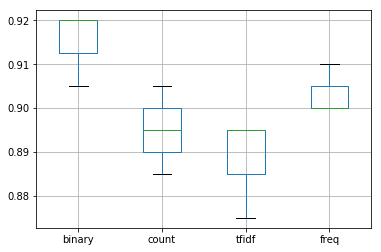

In [21]:
from matplotlib import pyplot
# summarize results
print(results.describe())
# plot results
results.boxplot()
pyplot.show()

In [29]:
Xtrain, Xtest = prepare_data(train_docs, test_docs, 'freq')
n_words = Xtest.shape[1]

model = Sequential()
model.add(Dense(50, input_shape = (n_words,), activation ='relu'))
model.add(Dense(1, activation = 'sigmoid'))

# compile network
model.compile(loss='binary_crossentropy',optimizer='adam', metrics=['accuracy'])

# fit network
model.fit(Xtrain, ytrain, epochs = 50, verbose = 2)

Epoch 1/50
 - 3s - loss: 0.6920 - acc: 0.5344
Epoch 2/50
 - 2s - loss: 0.6845 - acc: 0.8294
Epoch 3/50
 - 2s - loss: 0.6693 - acc: 0.8461
Epoch 4/50
 - 2s - loss: 0.6439 - acc: 0.9133
Epoch 5/50
 - 2s - loss: 0.6101 - acc: 0.9311
Epoch 6/50
 - 2s - loss: 0.5704 - acc: 0.9361
Epoch 7/50
 - 2s - loss: 0.5273 - acc: 0.9472
Epoch 8/50
 - 2s - loss: 0.4832 - acc: 0.9500
Epoch 9/50
 - 2s - loss: 0.4408 - acc: 0.9522
Epoch 10/50
 - 2s - loss: 0.4001 - acc: 0.9572
Epoch 11/50
 - 2s - loss: 0.3612 - acc: 0.9650
Epoch 12/50
 - 3s - loss: 0.3272 - acc: 0.9706
Epoch 13/50
 - 2s - loss: 0.2966 - acc: 0.9772
Epoch 14/50
 - 2s - loss: 0.2680 - acc: 0.9839
Epoch 15/50
 - 2s - loss: 0.2424 - acc: 0.9861
Epoch 16/50
 - 2s - loss: 0.2198 - acc: 0.9883
Epoch 17/50
 - 2s - loss: 0.1992 - acc: 0.9894
Epoch 18/50
 - 2s - loss: 0.1814 - acc: 0.9917
Epoch 19/50
 - 2s - loss: 0.1651 - acc: 0.9928
Epoch 20/50
 - 2s - loss: 0.1503 - acc: 0.9928
Epoch 21/50
 - 2s - loss: 0.1371 - acc: 0.9961
Epoch 22/50
 - 3s - lo

In [30]:
# classify a review as negative (0) or positive(1)
def predict_sentiment(review, vocab, tokenizer, model,mode):
#     clean
    tokens = clean_doc(review)
#     filter by vocab
    tokens = [w for w in tokens if w in vocab]
#     convert to line
    line = ' '.join(tokens)
#     encode
    encoded = tokenizer.texts_to_matrix([line], mode=mode)
#     prediction
    yhat = model.predict(encoded, verbose = 0)
    return yhat

In [31]:
# test positive text
text1 = 'Best movie ever'
print(predict_sentiment(text1,vocab,tokenizer, model,'freq'))

# test negative text
text2 = 'This is a bad movie'
print(predict_sentiment(text2,vocab,tokenizer, model,'freq'))

[[ 0.98100811]]
[[  1.32968709e-13]]
